In [1]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [2]:
class tSNE:
    def __init__(self, n_dimensions=2, perplexity=50, learning_rate=0.1, momentum=0.5, max_iter=1000):
        self.n_dimensions = n_dimensions
        self._perplexity = perplexity
        self._lr = learning_rate
        self._momentum = momentum
        self._max_iter = max_iter

        self.distances = None
        self.affinities = None
        self._perp_tol = 1e-10
        self.Y_distanes = None
        self.Y_affinities = None
        self.Y = None

    def fit(self, X):
        l = X.shape[0]
        self.distances = euclidean_distances(X)

        self.affinities = np.zeros((l, l))
        sigma = self.bin_search_sigma(X)
        self.affinities = self.full_cond_prob(sigma)
        self.affinities = (self.affinities + self.affinities.T) / (2 * l)

        Y = np.random.multivariate_normal(np.zeros(self.n_dimensions), np.identity(self.n_dimensions)*(1e-4), l)
        Y_1, Y_2 = Y, Y

        for _ in range(self._max_iter):
            self.Y_distanes = euclidean_distances(Y)
            self.Y_affinities = self.joint_prob()
            grad = self.gradient(Y)
            Y = Y - self._lr * grad + self._momentum * (Y_1 - Y_2)
            Y_2, Y_1 = Y_1, Y
        self.Y = Y

        return self

    def fit_transform(self, X):
        self.fit(X)
        return self.Y

    def gradient(self, Y):
        grad = np.zeros(Y.shape)
        for j in range(Y.shape[0]):
            grad += 4 * (self.affinities[:, j] - self.Y_affinities[:, j]).reshape(-1, 1) * (Y - Y[j]) * (1/(1+np.square(self.Y_distanes[:,j]))).reshape(-1, 1)
        return grad

    def full_cond_prob(self, sigma):
        nominator = np.exp((-1/2) * np.square(self.distances/sigma))
        denominator = nominator.sum(axis=1) - 1
        cond_prob = nominator/denominator.reshape(-1, 1)
        np.fill_diagonal(cond_prob, 1)
        return cond_prob

    def cond_prob(self, index, sigma):
        nominator = np.exp((-1/2) * np.square(self.distances[index]/sigma))
        denominator = nominator.sum() - 1
        cond_prob = nominator/denominator
        cond_prob[index] = 1
        self.affinities[index] = cond_prob

    def joint_prob(self):
        nominator = 1/(self.Y_distanes**2 + 1)
        denominator = nominator.sum() - nominator.trace()
        return nominator/denominator

    def shannon_entropy(self, cond_prob):
        return -1 * np.multiply(cond_prob, np.log2(cond_prob)).sum()

    def perplexity(self, H):
        return 2 ** H

    def bin_search_sigma(self, X):
        sigma_arr = np.ones(X.shape[0]) * np.std(X)
        for i in range(X.shape[0]):
            sigma = sigma_arr[i]
            search_range = sigma
            for _ in range(self._max_iter):
                self.cond_prob(i, sigma)
                perp = self.perplexity(self.shannon_entropy(self.affinities[i]))
                if self._perplexity - self._perp_tol < perp < self._perplexity + self._perp_tol:
                    break
                elif perp > self._perplexity:
                    sigma -= search_range/2
                else:
                    sigma += search_range/2
                search_range /= 2
            sigma_arr[i] = sigma
        return sigma_arr.reshape(-1, 1)


In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']

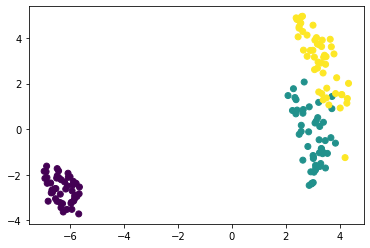

In [4]:
model = tSNE(learning_rate=50, max_iter=300)
Y = model.fit_transform(X)

plt.scatter(Y[:,0], Y[:,1], c=y)
plt.show()

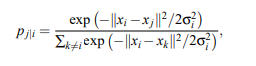

In [24]:
from IPython import display
display.Image("./condtitional probability.png")

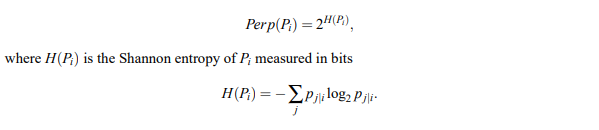

In [28]:
from IPython import display
display.Image("./perplexity.png")